In [5]:
import torch
from phasegrok.data_gen import generate_data
from phasegrok.utils import Logger, get_loss, mycolors
import numpy as np
from tqdm import tqdm
from boilerplate.utils.utils import make_path, make_grid, minmax_norm, get_rqi, get_lims
from torchmetrics.functional import accuracy
import matplotlib.pyplot as plt
from time import strftime
import glob 
import os
from tbparse import SummaryReader

plt.style.use('mystyle-bright')

from itertools import product, combinations
from matplotlib import colors as mcolors
from matplotlib import cm

In [6]:
seed = 0
split_ratio = 0.8
p = 11
m = 1

torch.manual_seed(seed)
pairs, train_indices, test_indices, best_acc = generate_data(p, seed, split_ratio,
                                                      ignore_symmetric=False,
                                                      batch_size=-1, compute_best_acc=False)
print(f"Best accuracy: {best_acc}")
P0 = []  # P0 is the set of all possible parallelograms
P = []
for pair1, pair2 in combinations(train_indices.dataset.tensors[0], 2):
    if sum(pair1) == sum(pair2):
        parallelogram = {pair1.data, pair2.data}
        P0.append(parallelogram)
        P.append(parallelogram)

for pair1, pair2 in combinations(test_indices.dataset.tensors[0], 2):
    if sum(pair1) == sum(pair2):
        parallelogram = {pair1.data, pair2.data}
        P0.append(parallelogram)                                               

device = 'cpu'
out_classes = m if m > 1 else 2 * p - 1

Best accuracy: None


In [3]:
seed_weights = 0 # 0 is a great seed
latent_dim = 2
depth = 2
width=128
weight_decay  = 5 # 5 is decent
log_step = 100

nums = torch.arange(p)
Y = nums + nums.view(-1, 1)
Y = Y % m if m > 1 else Y
Y = Y.long().to(device)

torch.manual_seed(seed_weights)
representation = (torch.randn(p, latent_dim) + 1) #* torch.arange(p).view(-1, 1) * torch.arange(latent_dim).view(1, -1).repeat(p, 1)

representation.to(device).requires_grad_()


model = [torch.nn.Linear(latent_dim, width), torch.nn.ReLU()]
model += [layer for layer in (torch.nn.Linear(width, width),
                      torch.nn.ReLU()) for _ in range(depth - 1)][:-1]
model += [torch.nn.Linear(width, out_classes)]
model = torch.nn.Sequential(*model).to(device)


param_groups = [{"params": (representation, ), "lr": 1e-3,
                "weight_decay": 0},  
                {"params": model.parameters(), "lr": 9e-5,
                "weight_decay": weight_decay}]

optimizer = torch.optim.AdamW(param_groups)
loss_func = get_loss('mse')

def step(idx):
    x = representation[idx]
    x = x.sum(1)/2
    pred = model(x)
    target = Y[idx[:, 0], idx[:, 1]]
    if loss_func == torch.nn.functional.mse_loss:
        loss = loss_func(pred, torch.nn.functional.one_hot(
            target, out_classes).float())
    else:
        loss = loss_func(pred, target)
    acc = accuracy(pred, target)
    return loss, acc

representation_steps = []
metrics_steps = {'loss/train': [], 'loss/test': [], 'acc/train': [], 'acc/test': [], "epoch": []}

logger = Logger(experiment="Add2Dgood", log_every=log_step, save_ckpt=True, save_weights=True, model=model, overwrite=True,
                hparam_dict={"latent_dim": latent_dim, "depth": depth, "width": width, "weight_decay": weight_decay, 
                "seed_weights": seed_weights, "seed": seed, "split_ratio": split_ratio, "p": p, "m": m})
epochs = 20000
pbar = tqdm(range(epochs))
for epoch in pbar:
    model.train()
    metrics = {}
    for idx, *_ in train_indices:
        optimizer.zero_grad()
        loss_train, acc_train = step(idx)
        loss_train.backward()
        optimizer.step()
    with torch.no_grad():
        model.eval()
        for idx, *_ in test_indices:
            loss_test, acc_test = step(idx)

    # logging
    msg = f"Loss {loss_train.item():.2e}|{loss_test.item():.2e} || "
    msg += f"Acc {acc_train:.3f}|{acc_test:.3f}"
    pbar.set_description(msg)

    # Logging metrics and embeddings
    metrics = {"loss/train": loss_train.item(), "loss/test": loss_test.item(),
               "acc/train": acc_train, "acc/test": acc_test}
    logger.log(metrics, representation.data, ckpt=model.state_dict())
    if epoch % log_step == 0:
        representation_steps.append(representation.data.clone())
        for k, v in metrics.items():
            metrics_steps[k].append(v)
        metrics_steps["epoch"].append(epoch)
logger.close()
    
timestamp = 'final' #strftime("%Y%m%d-%H%M")

Overwriting /home/kitouni/projects/Grok/grokking-squared/runs/Add1Dgood/


Loss 2.70e-02|3.81e-02 || Acc 0.573|0.320: 100%|██████████| 20000/20000 [01:41<00:00, 197.56it/s]

saved to /home/kitouni/projects/Grok/grokking-squared/runs/Add1Dgood/


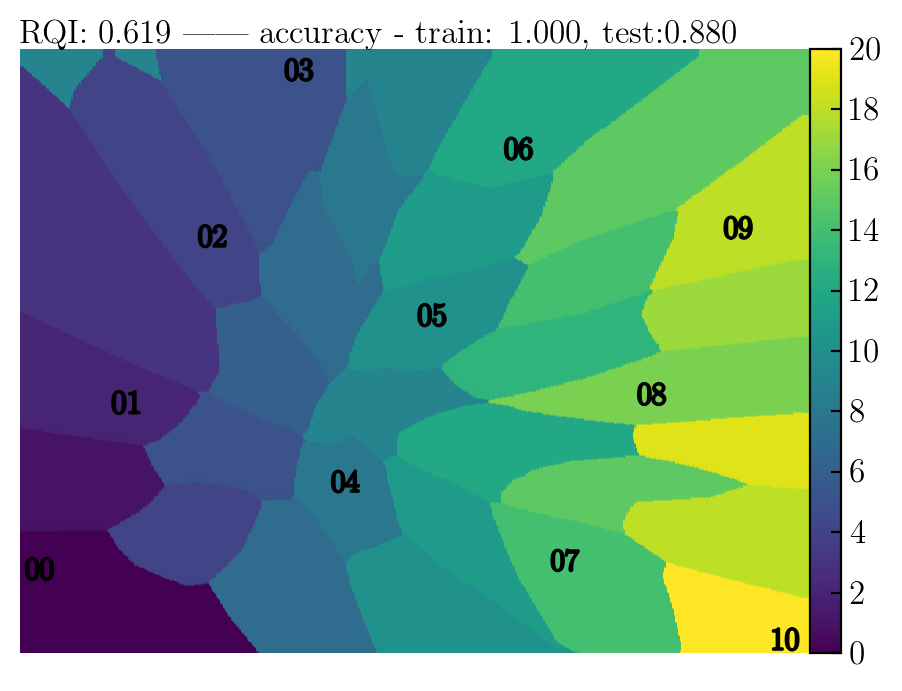

In [22]:
path = "/home/kitouni/projects/Grok/grokking-squared/runs/Add2Dgood/"
representation_files = glob.glob(path + "weights/*.embd")
model_files = glob.glob(path + "weights/*.ckpt")
model = torch.load(path+"model.pt")
scalars = SummaryReader(path, pivot=True).scalars
grid_fine = 500

n = len(representation_files) - 1
indices = [100]

for index in indices:
    embd = torch.load(representation_files[index])
    model.load_state_dict(torch.load(model_files[index]))
    acc_train = scalars["acc/train"][index]
    acc_test = scalars["acc/test"][index]
    rqi = get_rqi(P0, embd, eps=1e-3)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
    ax.text(0, 1.01, f"RQI: {rqi:.3f} || accuracy - train: {acc_train:.3f}, test:{acc_test:.3f}", transform=ax.transAxes, fontsize='large')
    grid = make_grid(embd.numpy(), n=grid_fine)
    pred = model(torch.tensor(grid).to(device).float()).argmax(1)
    sc = plt.scatter(*grid.T, c=pred, zorder=0, cmap='viridis', marker='s', s=4)
    # img = pred.reshape(int(np.sqrt(pred.shape[0])), -1)
    # sc = plt.imshow(img, extent=(grid[0, 0], grid[-1, 0], grid[0, 1], grid[-1, 1]), zorder=0, cmap='viridis')
    cbar = plt.colorbar(sc, pad=0)
    cbar.set_ticks(np.arange(0, out_classes, 2))
    if embd.shape[1] == 1:
        embd = np.hstack([embd, np.arange(p).reshape(-1, 1)])
    sc = plt.scatter(*embd.T, c='k', zorder=6, s=100)
    sc.set_paths([make_path(f"${m:02d}$") for m in range(p)])
    ax.set_axis_off()
    xlim, ylim = get_lims(grid, 0.01)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    name = path.split("/")[-1]
    # plt.savefig(f"../paper-plots/{name}{scalars['step'][index]}-{timestamp}.pdf", bbox_inches='tight')

In [14]:
seed = 0
split_ratio = 0.7
p = 11
m = 1

torch.manual_seed(seed)
pairs, train_indices, test_indices, best_acc = generate_data(p, seed, split_ratio,
                                                      ignore_symmetric=True,
                                                      batch_size=-1, compute_best_acc=True)
print(f"Best accuracy: {best_acc}")
P0 = []  # P0 is the set of all possible parallelograms
P = []
for pair1, pair2 in combinations(train_indices.dataset.tensors[0], 2):
    if sum(pair1) == sum(pair2):
        parallelogram = {pair1.data, pair2.data}
        P0.append(parallelogram)
        P.append(parallelogram)

for pair1, pair2 in combinations(test_indices.dataset.tensors[0], 2):
    if sum(pair1) == sum(pair2):
        parallelogram = {pair1.data, pair2.data}
        P0.append(parallelogram)                                               

seed_weights = 0 # 0 is a great seed
latent_dim = 2
device = 'cpu'
depth = 7
width=256
weight_decay  = 0 # 5 is decent
log_step = 100

nums = torch.arange(p)
Y = nums + nums.view(-1, 1)
Y = Y % m if m > 1 else Y
Y = Y.long().to(device)

torch.manual_seed(seed_weights)
representation = (torch.randn(p, latent_dim) + 1) #* torch.arange(p).view(-1, 1) * torch.arange(latent_dim).view(1, -1).repeat(p, 1)

representation.to(device).requires_grad_()
out_classes = m if m > 1 else 2 * p - 1


model = [torch.nn.Linear(latent_dim, width), torch.nn.ReLU()]
model += [layer for layer in (torch.nn.Linear(width, width),
                      torch.nn.ReLU()) for _ in range(depth - 1)][:-1]
model += [torch.nn.Linear(width, out_classes)]
model = torch.nn.Sequential(*model).to(device)


param_groups = [{"params": (representation, ), "lr": 2e-4,
                "weight_decay": 0},  
                {"params": model.parameters(), "lr": 1e-3,
                "weight_decay": weight_decay}]

optimizer = torch.optim.AdamW(param_groups)
loss_func = get_loss('mse')

def step(idx):
    x = representation[idx]
    x = x.sum(1)/2
    pred = model(x)
    target = Y[idx[:, 0], idx[:, 1]]
    if loss_func == torch.nn.functional.mse_loss:
        loss = loss_func(pred, torch.nn.functional.one_hot(
            target, out_classes).float())
    else:
        loss = loss_func(pred, target)
    acc = accuracy(pred, target)
    return loss, acc

representation_steps = []
metrics_steps = {'loss/train': [], 'loss/test': [], 'acc/train': [], 'acc/test': [], "epoch": []}


logger = Logger(experiment="Add2Dbad", log_every=log_step, save_ckpt=True, save_weights=True, model=model, overwrite=True,
                hparam_dict={"latent_dim": latent_dim, "depth": depth, "width": width, "weight_decay": weight_decay, 
                "seed_weights": seed_weights, "seed": seed, "split_ratio": split_ratio, "p": p, "m": m})
epochs = 401
pbar = tqdm(range(epochs))
for epoch in pbar:
    model.train()
    metrics = {}
    for idx, *_ in train_indices:
        optimizer.zero_grad()
        loss_train, acc_train = step(idx)
        loss_train.backward()
        optimizer.step()
    with torch.no_grad():
        model.eval()
        for idx, *_ in test_indices:
            loss_test, acc_test = step(idx)

    # logging
    msg = f"Loss {loss_train.item():.2e}|{loss_test.item():.2e} || "
    msg += f"Acc {acc_train:.3f}|{acc_test:.3f}"
    pbar.set_description(msg)

    # Logging metrics and embeddings
    metrics = {"loss/train": loss_train.item(), "loss/test": loss_test.item(),
               "acc/train": acc_train, "acc/test": acc_test}
    logger.log(metrics, representation.data, ckpt=model.state_dict())
    if epoch % log_step == 0:
        representation_steps.append(representation.data.clone())
        for k, v in metrics.items():
            metrics_steps[k].append(v)
        metrics_steps["epoch"].append(epoch)
logger.close()
    
timestamp = "final" #strftime("%Y%m%d-%H%M")

Best accuracy: 1.0
Overwriting /home/kitouni/projects/Grok/grokking-squared/runs/Add2Dbad/


Loss 5.27e-03|1.13e-01 || Acc 1.000|0.056: 100%|██████████| 401/401 [00:03<00:00, 132.77it/s]

saved to /home/kitouni/projects/Grok/grokking-squared/runs/Add2Dbad/


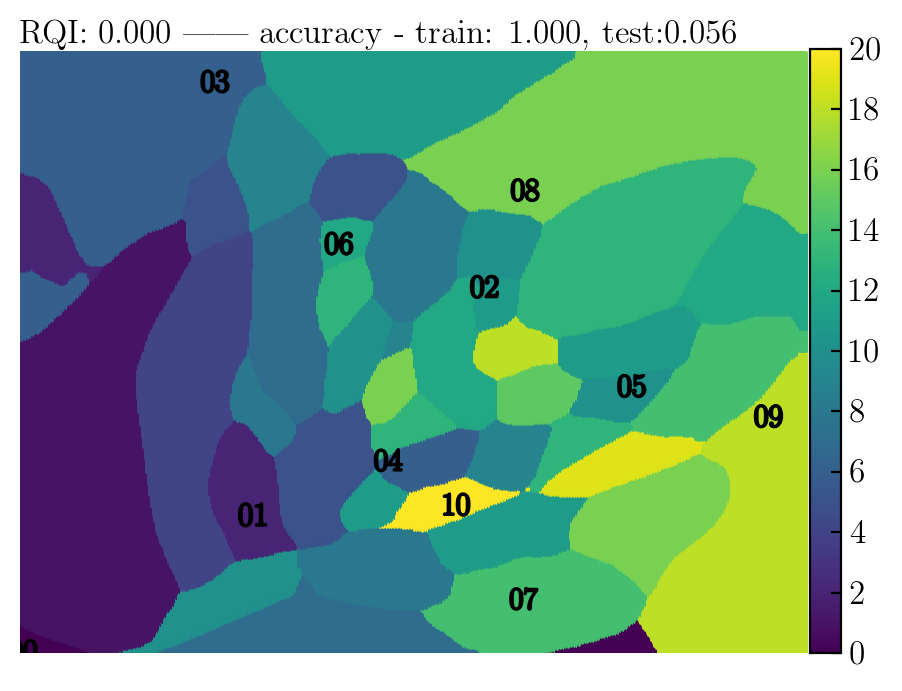

In [15]:
path = "/home/kitouni/projects/Grok/grokking-squared/runs/Add2Dbad/"
representation_files = glob.glob(path + "weights/*.embd")
model_files = glob.glob(path + "weights/*.ckpt")
model = torch.load(path+"model.pt")
scalars = SummaryReader(path, pivot=True).scalars
grid_fine = 500

n = len(representation_files) - 1
indices = [n]

for index in indices:
    embd = torch.load(representation_files[index])
    model.load_state_dict(torch.load(model_files[index]))
    acc_train = scalars["acc/train"][index]
    acc_test = scalars["acc/test"][index]
    rqi = get_rqi(P0, embd, eps=1e-3)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
    ax.text(0, 1.01, f"RQI: {rqi:.3f} || accuracy - train: {acc_train:.3f}, test:{acc_test:.3f}", transform=ax.transAxes, fontsize='large')
    grid = make_grid(embd.numpy(), n=grid_fine)
    pred = model(torch.tensor(grid).to(device).float()).argmax(1)
    sc = plt.scatter(*grid.T, c=pred, zorder=0, cmap='viridis', marker='s', s=4)
    cbar = plt.colorbar(sc, pad=0)
    cbar.set_ticks(np.arange(0, out_classes, 2))
    if embd.shape[1] == 1:
        embd = np.hstack([embd, np.arange(p).reshape(-1, 1)])
    sc = plt.scatter(*embd.T, c='k', zorder=6, s=100)
    sc.set_paths([make_path(f"${m:02d}$") for m in range(p)])
    ax.set_axis_off()
    xlim, ylim = get_lims(grid, 0.01)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    name = path.split("/")[-1]
    plt.savefig(f"../paper-plots/{name}{scalars['step'][index]}-{timestamp}.pdf", bbox_inches='tight')

# One dimensional

In [13]:
import time
seed = 0
split_ratio = 0.8
p = 11
m = 1
timestamp = time.strftime("%Y%m%d-%H%M")
experiment = "Add1Dgood-{}".format(timestamp)
torch.manual_seed(seed)
pairs, train_indices, test_indices, best_acc = generate_data(p, seed, split_ratio,
                                                      ignore_symmetric=False,
                                                      batch_size=-1, compute_best_acc=False)
print(f"Best accuracy: {best_acc}")
P0 = []  # P0 is the set of all possible parallelograms
P = []
for pair1, pair2 in combinations(train_indices.dataset.tensors[0], 2):
    if sum(pair1) == sum(pair2):
        parallelogram = {pair1.data, pair2.data}
        P0.append(parallelogram)
        P.append(parallelogram)

for pair1, pair2 in combinations(test_indices.dataset.tensors[0], 2):
    if sum(pair1) == sum(pair2):
        parallelogram = {pair1.data, pair2.data}
        P0.append(parallelogram)                                               
        
seed_weights = 1 # 0 is a great seed
latent_dim = 1
device = 'cpu'
depth = 4
width=128
weight_decay  = 3 # 5 is decent
log_step = 100

nums = torch.arange(p)
Y = nums + nums.view(-1, 1)
Y = Y % m if m > 1 else Y
Y = Y.long().to(device)

torch.manual_seed(seed_weights)
representation = (torch.randn(p, latent_dim)) #* torch.arange(p).view(-1, 1) * torch.arange(latent_dim).view(1, -1).repeat(p, 1)

representation.to(device).requires_grad_()
out_classes = m if m > 1 else 2 * p - 1


model = [torch.nn.Linear(latent_dim, width), torch.nn.LeakyReLU()]
model += [layer for layer in (torch.nn.Linear(width, width),
                      torch.nn.LeakyReLU()) for _ in range(depth - 1)][:-1]
model += [torch.nn.Linear(width, out_classes)]
model = torch.nn.Sequential(*model).to(device)


param_groups = [{"params": (representation, ), "lr": 1e-3,
                "weight_decay": 0},  
                {"params": model.parameters(), "lr": 9e-5,
                "weight_decay": weight_decay}]

optimizer = torch.optim.AdamW(param_groups)
loss_func = get_loss('mse')

def step(idx):
    x = representation[idx]
    x = x.sum(1)/2
    pred = model(x)
    target = Y[idx[:, 0], idx[:, 1]]
    if loss_func == torch.nn.functional.mse_loss:
        loss = loss_func(pred, torch.nn.functional.one_hot(
            target, out_classes).float())
    else:
        loss = loss_func(pred, target)
    acc = accuracy(pred, target)
    return loss, acc

representation_steps = []
metrics_steps = {'loss/train': [], 'loss/test': [], 'acc/train': [], 'acc/test': [], "epoch": []}


logger = Logger(experiment=experiment, log_every=log_step, save_ckpt=True, save_weights=True, model=model, overwrite=True,
                hparam_dict={"latent_dim": latent_dim, "depth": depth, "width": width, "weight_decay": weight_decay, 
                "seed_weights": seed_weights, "seed": seed, "split_ratio": split_ratio, "p": p, "m": m})
epochs = 20000
pbar = tqdm(range(epochs))
for epoch in pbar:
    model.train()
    metrics = {}
    for idx, *_ in train_indices:
        optimizer.zero_grad()
        loss_train, acc_train = step(idx)
        loss_train.backward()
        optimizer.step()
    with torch.no_grad():
        model.eval()
        for idx, *_ in test_indices:
            loss_test, acc_test = step(idx)

    # logging
    msg = f"Loss {loss_train.item():.2e}|{loss_test.item():.2e} || "
    msg += f"Acc {acc_train:.3f}|{acc_test:.3f}"
    pbar.set_description(msg)

    # Logging metrics and embeddings
    metrics = {"loss/train": loss_train.item(), "loss/test": loss_test.item(),
               "acc/train": acc_train, "acc/test": acc_test}
    logger.log(metrics, representation.data, ckpt=model.state_dict())
    if epoch % log_step == 0:
        representation_steps.append(representation.data.clone())
        for k, v in metrics.items():
            metrics_steps[k].append(v)
        metrics_steps["epoch"].append(epoch)
logger.close()
    
timestamp = 'final' #strftime("%Y%m%d-%H%M")

Best accuracy: None


Loss 1.53e-03|5.82e-03 || Acc 0.990|0.880: 100%|██████████| 20000/20000 [01:52<00:00, 177.59it/s]


saved to /home/kitouni/projects/Grok/grokking-squared/runs/Add1Dgood-20220515-1807/


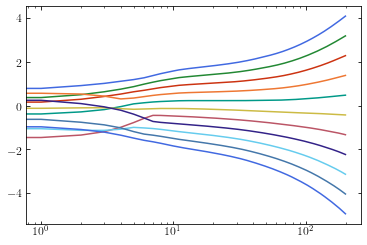

In [15]:
experiment = "Add1Dgood-20220515-1807"
path = f"/home/kitouni/projects/Grok/grokking-squared/runs/{experiment}/"
representation_files = glob.glob(path + "weights/*.embd")
embds = []
for index in range(len(representation_files)):
    embd = torch.load(representation_files[index])
    embds.append(embd.flatten().numpy())
embds = np.array(embds)
plt.plot(embds)
plt.xscale('log')

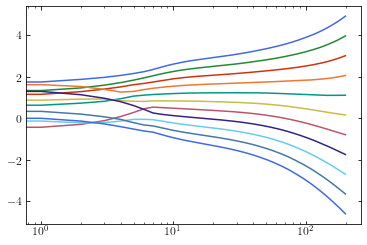

In [14]:
experiment = "Add1Dgood"
path = f"/home/kitouni/projects/Grok/grokking-squared/runs/{experiment}/"
representation_files = glob.glob(path + "weights/*.embd")
embds = []
for index in range(len(representation_files)):
    embd = torch.load(representation_files[index])
    embds.append(embd.flatten().numpy())
embds = np.array(embds)
plt.plot(embds)
plt.xscale('log')

In [7]:
seed = 0
split_ratio = 0.8
p = 11
m = 1
experiment = "Add1Dgood"
torch.manual_seed(seed)
pairs, train_indices, test_indices, best_acc = generate_data(p, seed, split_ratio,
                                                      ignore_symmetric=False,
                                                      batch_size=-1, compute_best_acc=False)
print(f"Best accuracy: {best_acc}")
P0 = []  # P0 is the set of all possible parallelograms
P = []
for pair1, pair2 in combinations(train_indices.dataset.tensors[0], 2):
    if sum(pair1) == sum(pair2):
        parallelogram = {pair1.data, pair2.data}
        P0.append(parallelogram)
        P.append(parallelogram)

for pair1, pair2 in combinations(test_indices.dataset.tensors[0], 2):
    if sum(pair1) == sum(pair2):
        parallelogram = {pair1.data, pair2.data}
        P0.append(parallelogram)                                               
        
seed_weights = 1 # 0 is a great seed
latent_dim = 1
device = 'cpu'
depth = 4
width=128
weight_decay  = 3 # 5 is decent
log_step = 100

nums = torch.arange(p)
Y = nums + nums.view(-1, 1)
Y = Y % m if m > 1 else Y
Y = Y.long().to(device)

torch.manual_seed(seed_weights)
representation = (torch.randn(p, latent_dim) + 1) #* torch.arange(p).view(-1, 1) * torch.arange(latent_dim).view(1, -1).repeat(p, 1)

representation.to(device).requires_grad_()
out_classes = m if m > 1 else 2 * p - 1


model = [torch.nn.Linear(latent_dim, width), torch.nn.LeakyReLU()]
model += [layer for layer in (torch.nn.Linear(width, width),
                      torch.nn.LeakyReLU()) for _ in range(depth - 1)][:-1]
model += [torch.nn.Linear(width, out_classes)]
model = torch.nn.Sequential(*model).to(device)


param_groups = [{"params": (representation, ), "lr": 1e-3,
                "weight_decay": 0},  
                {"params": model.parameters(), "lr": 9e-5,
                "weight_decay": weight_decay}]

optimizer = torch.optim.AdamW(param_groups)
loss_func = get_loss('mse')

def step(idx):
    x = representation[idx]
    x = x.sum(1)/2
    pred = model(x)
    target = Y[idx[:, 0], idx[:, 1]]
    if loss_func == torch.nn.functional.mse_loss:
        loss = loss_func(pred, torch.nn.functional.one_hot(
            target, out_classes).float())
    else:
        loss = loss_func(pred, target)
    acc = accuracy(pred, target)
    return loss, acc

representation_steps = []
metrics_steps = {'loss/train': [], 'loss/test': [], 'acc/train': [], 'acc/test': [], "epoch": []}


logger = Logger(experiment=experiment, log_every=log_step, save_ckpt=True, save_weights=True, model=model, overwrite=True,
                hparam_dict={"latent_dim": latent_dim, "depth": depth, "width": width, "weight_decay": weight_decay, 
                "seed_weights": seed_weights, "seed": seed, "split_ratio": split_ratio, "p": p, "m": m})
epochs = 20000
pbar = tqdm(range(epochs))
for epoch in pbar:
    model.train()
    metrics = {}
    for idx, *_ in train_indices:
        optimizer.zero_grad()
        loss_train, acc_train = step(idx)
        loss_train.backward()
        optimizer.step()
    with torch.no_grad():
        model.eval()
        for idx, *_ in test_indices:
            loss_test, acc_test = step(idx)

    # logging
    msg = f"Loss {loss_train.item():.2e}|{loss_test.item():.2e} || "
    msg += f"Acc {acc_train:.3f}|{acc_test:.3f}"
    pbar.set_description(msg)

    # Logging metrics and embeddings
    metrics = {"loss/train": loss_train.item(), "loss/test": loss_test.item(),
               "acc/train": acc_train, "acc/test": acc_test}
    logger.log(metrics, representation.data, ckpt=model.state_dict())
    if epoch % log_step == 0:
        representation_steps.append(representation.data.clone())
        for k, v in metrics.items():
            metrics_steps[k].append(v)
        metrics_steps["epoch"].append(epoch)
logger.close()
    
timestamp = 'final' #strftime("%Y%m%d-%H%M")

KeyboardInterrupt: 

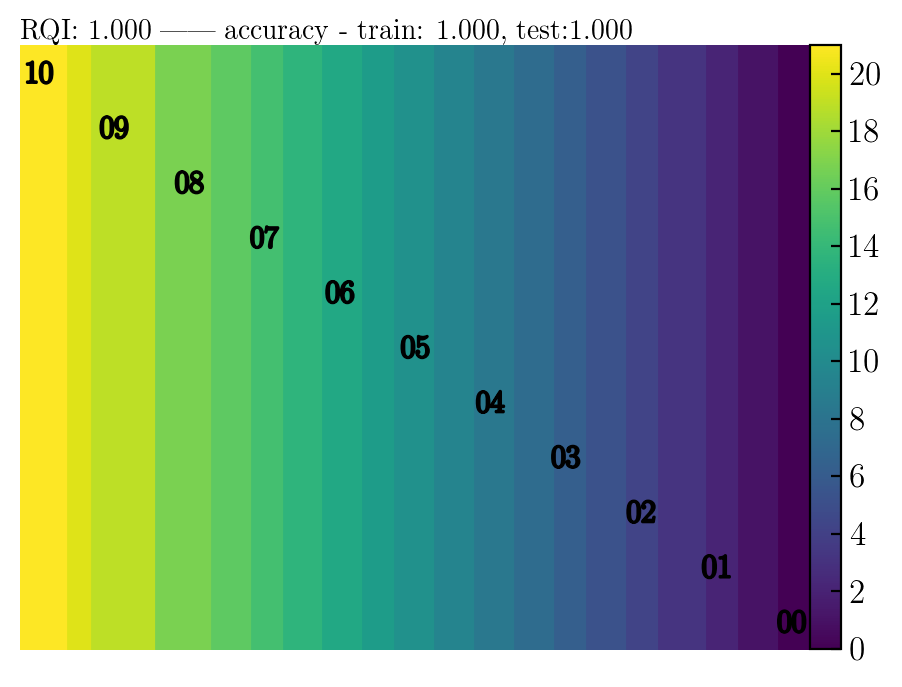

In [5]:
path = "/home/kitouni/projects/Grok/grokking-squared/runs/Add1Dgood/"
representation_files = glob.glob(path + "weights/*.embd")
model_files = glob.glob(path + "weights/*.ckpt")
model = torch.load(path+"model.pt")
scalars = SummaryReader(path, pivot=True).scalars
grid_fine = 100

n = len(representation_files) - 1
indices = [n]
cmap = plt.get_cmap('viridis')

for index in indices:
    embd = torch.load(representation_files[index])
    model.load_state_dict(torch.load(model_files[index]))
    acc_train = scalars["acc/train"][index]
    acc_test = scalars["acc/test"][index]
    rqi = get_rqi(P0, embd, eps=1e-3)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
    ax.text(0, 1.01, f"RQI: {rqi:.3f} || accuracy - train: {acc_train:.3f}, test:{acc_test:.3f}", transform=ax.transAxes)

    # Prediction Colors
    grid = make_grid(embd.numpy(), n=grid_fine)
    pred = model(torch.tensor(grid).to(device).float()).argmax(1).numpy()
    colors = cmap(minmax_norm(pred))
    for i, (lower, upper) in enumerate(zip(grid, grid[1:])):
        plt.fill_betweenx([-0.5, p-0.5], lower, upper, color=colors[i], alpha=1)
    # cleanup
    ax.set_axis_off()
    ax.set_xlim(grid[0], grid[-1])
    ax.set_ylim(-0.5, p-0.5)

    # Prediction Line
    ax1 = ax.twinx()
    # ax1.plot(grid, pred, 'k', alpha=1)
    ax1.set_yticks(np.arange(0, out_classes, 2))
    ax1.set_ylim(0, out_classes)
    ax1.set_axis_off()
    cbar = plt.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=0, vmax=out_classes), cmap=cmap), ax=ax1, use_gridspec=True, fraction=0.15, pad=0.0)
    cbar.set_ticks(np.arange(0, out_classes, 2))

    # Plot embeddings
    if embd.shape[1] == 1:
        embd = np.hstack([embd, np.arange(p).reshape(-1, 1)])
    sc = ax.scatter(*embd.T, c='k', zorder=6, s=100)
    sc.set_paths([make_path(f"${m:02d}$") for m in range(p)])

    name = path.split("/")[-1]
    # plt.savefig(f"../paper-plots/{name}{scalars['step'][index]}-{timestamp}.pdf", bbox_inches='tight')

In [10]:
seed = 0
split_ratio = 0.7
p = 11
m = 1

torch.manual_seed(seed)
pairs, train_indices, test_indices, best_acc = generate_data(p, seed, split_ratio,
                                                      ignore_symmetric=True,
                                                      batch_size=-1, compute_best_acc=False)
print(f"Best accuracy: {best_acc}")
P0 = []  # P0 is the set of all possible parallelograms
P = []
for pair1, pair2 in combinations(train_indices.dataset.tensors[0], 2):
    if sum(pair1) == sum(pair2):
        parallelogram = {pair1.data, pair2.data}
        P0.append(parallelogram)
        P.append(parallelogram)

for pair1, pair2 in combinations(test_indices.dataset.tensors[0], 2):
    if sum(pair1) == sum(pair2):
        parallelogram = {pair1.data, pair2.data}
        P0.append(parallelogram)         

seed_weights = 42 # 0 is a great seed
latent_dim = 1
device = 'cpu'
depth = 3
width=256
weight_decay  = 0 # 5 is decent
log_step = 100

nums = torch.arange(p)
Y = nums + nums.view(-1, 1)
Y = Y % m if m > 1 else Y
Y = Y.long().to(device)

torch.manual_seed(seed_weights)
representation = (torch.randn(p, latent_dim) + 1) #* torch.arange(p).view(-1, 1) * torch.arange(latent_dim).view(1, -1).repeat(p, 1)

representation.to(device).requires_grad_()
out_classes = m if m > 1 else 2 * p - 1


model = [torch.nn.Linear(latent_dim, width), torch.nn.LeakyReLU()]
model += [layer for layer in (torch.nn.Linear(width, width),
                      torch.nn.LeakyReLU()) for _ in range(depth - 1)][:-1]
model += [torch.nn.Linear(width, out_classes)]
model = torch.nn.Sequential(*model).to(device)


param_groups = [{"params": (representation, ), "lr": 1e-4,
                "weight_decay": 0},  
                {"params": model.parameters(), "lr": 1e-4,
                "weight_decay": weight_decay}]

optimizer = torch.optim.AdamW(param_groups)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=1, epochs=epochs+1)
loss_func = get_loss('mse')

def step(idx):
    x = representation[idx]
    x = x.sum(1)/2
    pred = model(x)
    target = Y[idx[:, 0], idx[:, 1]]
    if loss_func == torch.nn.functional.mse_loss:
        loss = loss_func(pred, torch.nn.functional.one_hot(
            target, out_classes).float())
    else:
        loss = loss_func(pred, target)
    acc = accuracy(pred, target)
    return loss, acc

representation_steps = []
metrics_steps = {'loss/train': [], 'loss/test': [], 'acc/train': [], 'acc/test': [], "epoch": []}


logger = Logger(experiment="Add1Dbad", log_every=log_step, save_ckpt=True, save_weights=True, model=model, overwrite=True,
                hparam_dict={"latent_dim": latent_dim, "depth": depth, "width": width, "weight_decay": weight_decay, 
                "seed_weights": seed_weights, "seed": seed, "split_ratio": split_ratio, "p": p, "m": m})
epochs = 20000
pbar = tqdm(range(epochs))
for epoch in pbar:
    model.train()
    metrics = {}
    for idx, *_ in train_indices:
        optimizer.zero_grad()
        loss_train, acc_train = step(idx)
        loss_train.backward()
        optimizer.step()
        scheduler.step()
    with torch.no_grad():
        model.eval()
        for idx, *_ in test_indices:
            loss_test, acc_test = step(idx)

    # logging
    msg = f"Loss {loss_train.item():.2e}|{loss_test.item():.2e} || "
    msg += f"Acc {acc_train:.3f}|{acc_test:.3f}"
    pbar.set_description(msg)

    # Logging metrics and embeddings
    metrics = {"loss/train": loss_train.item(), "loss/test": loss_test.item(),
               "acc/train": acc_train, "acc/test": acc_test}
    logger.log(metrics, representation.data, ckpt=model.state_dict())
    if epoch % log_step == 0:
        representation_steps.append(representation.data.clone())
        for k, v in metrics.items():
            metrics_steps[k].append(v)
        metrics_steps["epoch"].append(epoch)
logger.close()
    
timestamp = 'final' #strftime("%Y%m%d-%H%M")


Best accuracy: None
Overwriting /home/kitouni/projects/Grok/grokking-squared/runs/Add1Dbad/


Loss 3.33e-03|2.26e-01 || Acc 1.000|0.000: 100%|██████████| 20000/20000 [01:53<00:00, 175.91it/s]

saved to /home/kitouni/projects/Grok/grokking-squared/runs/Add1Dbad/


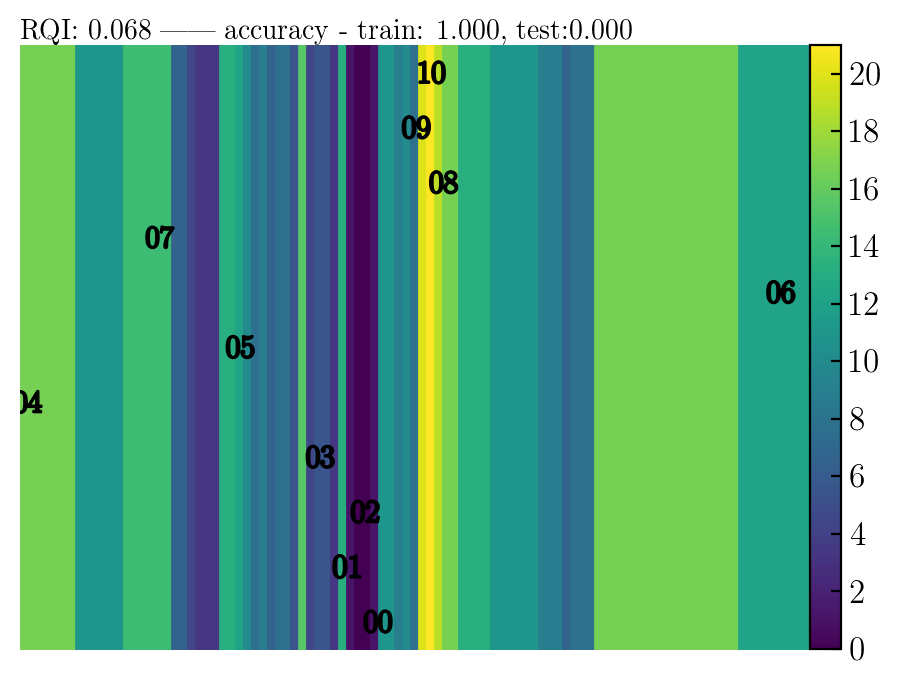

In [11]:
path = "/home/kitouni/projects/Grok/grokking-squared/runs/Add1Dbad/"
representation_files = glob.glob(path + "weights/*.embd")
model_files = glob.glob(path + "weights/*.ckpt")
model = torch.load(path+"model.pt")
scalars = SummaryReader(path, pivot=True).scalars
grid_fine = 100

n = len(representation_files) - 1
indices = [n]
cmap = plt.get_cmap('viridis')

for index in indices:
    embd = torch.load(representation_files[index])
    model.load_state_dict(torch.load(model_files[index]))
    acc_train = scalars["acc/train"][index]
    acc_test = scalars["acc/test"][index]
    rqi = get_rqi(P0, embd, eps=1e-3)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
    ax.text(0, 1.01, f"RQI: {rqi:.3f} || accuracy - train: {acc_train:.3f}, test:{acc_test:.3f}", transform=ax.transAxes)

    # Prediction Colors
    grid = make_grid(embd.numpy(), n=grid_fine)
    pred = model(torch.tensor(grid).to(device).float()).argmax(1).numpy()
    colors = cmap(minmax_norm(pred))
    for i, (lower, upper) in enumerate(zip(grid, grid[1:])):
        plt.fill_betweenx([-0.5, p-0.5], lower, upper, color=colors[i], alpha=1)
    # cleanup
    ax.set_axis_off()
    ax.set_xlim(grid[0], grid[-1])
    ax.set_ylim(-0.5, p-0.5)

    # Prediction Line
    ax1 = ax.twinx()
    # ax1.plot(grid, pred, 'k', alpha=1)
    ax1.set_yticks(np.arange(0, out_classes, 2))
    ax1.set_ylim(0, out_classes)
    ax1.set_axis_off()
    cbar = plt.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=0, vmax=out_classes), cmap=cmap), ax=ax1, use_gridspec=True, fraction=0.15, pad=0.0)
    cbar.set_ticks(np.arange(0, out_classes, 2))

    # Plot embeddings
    if embd.shape[1] == 1:
        embd = np.hstack([embd, np.arange(p).reshape(-1, 1)])
    sc = ax.scatter(*embd.T, c='k', zorder=6, s=100)
    sc.set_paths([make_path(f"${m:02d}$") for m in range(p)])

    name = path.split("/")[-1]
    # plt.savefig(f"../paper-plots/{name}{scalars['step'][index]}-{timestamp}.pdf", bbox_inches='tight')